In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir data
!tar -xf /content/gdrive/MyDrive/track_1.tar -C data

In [ ]:
!pip install timm albumentations catalyst

In [ ]:
from pprint import pprint
import pandas as pd
import time
import shutil
import numpy as np
import gc
import torch
import re
import os
import albumentations as A
import pickle
import timm
import cv2
import copy
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


**Custom DataSet**

In [ ]:
DATA_MODES = ['train', 'test', 'val']
IMAGE_SIZE = (224, 224) #(576, 576)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class IDAODataset(Dataset):
    def __init__(self, files, mode, augmentation=None):
        self.files = files
        self.mode = mode
        self.augmentation = augmentation
        if self.mode not in DATA_MODES:
            raise NameError('Current mode not in data modes')
        self.len = len(self.files)
        if mode == 'val':
            self.label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
        else:
            self.label_encoder = LabelEncoder()

        if mode != 'test':
            self.labels = {'classification': [path.parent.name for path in self.files],
                           'regression': [int(re.search(r'[EN]R_(\d+)', file.name)
                           .group(1))
                           for file in self.files]}
        if self.mode == 'train':
            self.label_encoder.fit(self.labels['classification'])
            with open('label_encoder.pkl', 'wb') as le_dump:
                pickle.dump(self.label_encoder, le_dump)

    def __len__(self):
        return self.len
    
    @staticmethod
    def crop(img, size=IMAGE_SIZE, stride=32):
        m, ms = (0, 0), 0
        for i in range(0, img.shape[0] - size[0], stride):
            for j in range(0, img.shape[1] - size[1], stride):
                cs = img[
                        i: i + size[0], 
                        j: j + size[1]
                    ].sum()
                if cs > ms:
                    m, ms = (i, j), cs
        return img[m[0]: m[0] + size[0], m[1]: m[1] + size[1]]
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        """Here image could be processed"""
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        return self.crop(np.array(image))

    def show_image(self, index):
        image = self.load_sample(self.files[index])
        image.show()

    def __getitem__(self, index):
        if index < 0 or index > len(self.files):
            raise IndexError()
        image = self.load_sample(self.files[index])
        image = image.resize(IMAGE_SIZE)
        image = np.array(np.array(image) / 225, dtype='float32')
        image = self._prepare_sample(image)

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.45], std=[0.246])  #random_values, should be found
        ])

        image = transform(image)
        if self.mode == 'test':
            return image
        if self.augmentation is not None:
            image = augmentation(image=image)["image"]
        label_cl = self.label_encoder.transform([self.labels['classification'][index]]).item()
        label_reg = self.labels['regression'][index]
        return image, label_cl, label_reg


**Creating loaders**

In [ ]:
TRAIN_DIR = Path("./data/idao_dataset/train")
train_val_files = sorted(list(TRAIN_DIR.rglob('*.png')))

In [ ]:
def show_image(file, label=None):
    image = Image.open(file)
    if label is None:
        label=''
    plt.imshow(image, label=label)

data/idao_dataset/train/ER/-0.003018522635102272__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev121;1.png


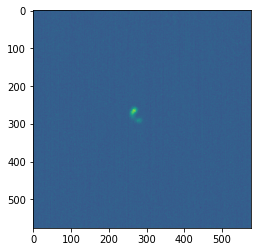

In [ ]:
print(train_val_files[0])
show_image(train_val_files[0])

In [ ]:
TRAIN_SIZE = 0.95
BATCH_SIZE = 64
X_train, X_val = train_test_split(train_val_files, train_size=TRAIN_SIZE, shuffle=True)

train_set = IDAODataset(X_train, mode='train')
val_set = IDAODataset(X_val, mode='val')
train_val_loader = {'train' : DataLoader(train_set, batch_size=BATCH_SIZE),
                    'val' : DataLoader(val_set, batch_size=BATCH_SIZE)}

In [ ]:
def vizualize_loss(loss, num_epochs=None):
    if num_epochs is None:
        epochs = range(1, len(loss['train']) + 1)
    else:
        epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss['train'], 'g', label='Training loss')
    plt.plot(epochs, loss['val'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

def train(model, loader, optimizer, criterion, num_epochs=10, scheduler=None, 
          phases=['train', 'val']):
    '''
    Expect loader to be a dict with 'train' and 'val' keys
    '''

    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000.0
    history = {'train' : {'loss' : [], 'loss_cl' :[], 'loss_reg': []}, 
               'val': {'loss' : [], 'loss_cl' : [], 'loss_reg': []}}

    for i in range(num_epochs):
        print(f'Epoch: {i+1} / {num_epochs}')
        print('-'*10)
        for phase in phases:
            model.train(phase == 'train')
            
            running_loss = 0.
            running_loss_reg = 0.
            running_loss_cl = 0.
            processed_size = 0

            for inputs, labels_cl, labels_reg in loader[phase]:
                inputs = inputs.to(device)
                labels_cl = labels_cl.to(device).double()
                labels_reg = labels_reg.to(device).double()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_cl, outputs_reg = model(inputs)
                    outputs_cl = outputs_cl.squeeze().double()
                    outputs_reg = outputs_reg.squeeze().double()
                    loss_cl = criterion['classification'](outputs_cl, labels_cl)
                    loss_reg = criterion['regression'](outputs_reg, labels_reg)
                    loss = loss_cl + loss_reg
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss_reg += loss_reg
                running_loss += loss
                running_loss_cl += loss_cl

                processed_size += inputs.size(0)
            
            phase_loss_cl = running_loss_cl / processed_size
            phase_loss_reg = running_loss_reg / processed_size
            phase_loss = running_loss / processed_size

            if phase == 'val' and phase_loss < best_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = phase_loss

            print(f'{phase}  loss: {phase_loss}  loss_cl: {phase_loss_cl}  loss_reg: {phase_loss_reg}')
            history[phase]['loss'].append(phase_loss)
            history[phase]['loss_cl'].append(phase_loss_cl)
            history[phase]['loss_reg'].append(phase_loss_reg)
        if scheduler is not None:
            scheduler.step()
    print(f'Elapsed time: {str(time.ctime(time.time() - start_time))}')
    return model, history, best_model_wts

In [ ]:
class IDAONet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b1_ns', num_classes=0).to(device)
        self.head = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU()
        ).to(device)
        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)

        self.regressor = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        ).to(device)
    def forward(self, x):
        x = self.model.forward(x)
        res_cl = self.classifier(x)
        res_reg = self.regressor(x)
        return res_cl, res_reg

In [ ]:
model = IDAONet()
criterion_cl = nn.BCELoss()
criterion_reg = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.95)

In [ ]:
gc.collect()
num_epochs = 20
model, history, best_weights = train(model, loader=train_val_loader, num_epochs=num_epochs, 
                       optimizer=optimizer, scheduler=scheduler, criterion=
                       {'classification': criterion_cl,
                        'regression': criterion_reg})

In [ ]:
vizualize_loss({'train': history['train']['loss'], 'val': history['val']['loss']}, num_epochs=num_epochs)

**Make submission**


In [ ]:
def round_nearest(a):
    nums = [1, 3, 6, 10, 20, 30]
    for i in range(len(a)):
        mi = float("INF")
        res = 1
        for num in nums:
            if abs(a[i] - num) < mi:
                mi = abs(a[i] - num)
                res = num
        a[i] = res
    return a


In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        res = {'classification': np.empty(shape=(0)),
               'regression': np.empty(shape=(0))}
 
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs_cl, outputs_reg = model(inputs)
            outputs_cl = np.array(outputs_cl.cpu().squeeze())
            outputs_reg = np.array(outputs_reg.cpu().squeeze())
            res['classification'] = np.concatenate((res['classification'], outputs_cl), axis=None)
            res['regression'] = np.concatenate((res['regression'], outputs_reg), axis=None)
    return res
 
TEST_DIR_PUBLIC = Path("./data/idao_dataset/public_test")
TEST_DIR_PRIVATE = Path("./data/idao_dataset/private_test")
test_files = sorted(list(TEST_DIR_PUBLIC.rglob('*.png')) + list(TEST_DIR_PRIVATE.rglob("*.png")))
print(f'Num test files: {len(test_files)}')
test_set = IDAODataset(test_files, mode='test')
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
submit = pd.DataFrame(columns=['id'])
submit['id'] = [path.name.replace('.png', '') for path in test_set.files]
model = IDAONet().to(device)
model.load_state_dict(best_weights)
probs = predict(model, test_loader)
preds_cl = label_encoder.inverse_transform(np.round(probs['classification']).astype(int))
convert_to_int = {
    'ER': 1,
    'NR': 0,
}
submit['classification_predictions'] = [convert_to_int[i] for i in preds_cl]

preds_reg = round_nearest(list(probs['regression']))
submit['regression_predictions'] = preds_reg

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
torch.save(model.state_dict(), 'model_state_dict')